# Preprocessing

### Importing libraries and datasets

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cleaning_functions as cf 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score


In [32]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
red_file_path = '../data/cleaned/winequality_red_cleaned.csv'
white_file_path = '../data/cleaned/winequality_white_cleaned.csv'
combined_df = pd.read_csv(combined_file_path)
red_df = pd.read_csv(red_file_path, index_col=0)
white_df = pd.read_csv(white_file_path, index_col=0)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
3957,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
3958,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
3959,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [33]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    
    # Applying model to X test
    y_pred = model.predict(X_test)
    
    # Ensure y_test is in the correct format (pandas Series or 1D numpy array)
    if isinstance(y_test, pd.Series):
        y_test_reset = y_test.reset_index(drop=True)
    else:
        y_test_reset = y_test  # Assuming y_test is already a numpy array
    
    # Creating combined table with y_test and y_pred
    # Check if y_test_reset is a pandas Series and convert y_pred to a similar type
    if isinstance(y_test_reset, pd.Series):
        y_pred_series = pd.Series(y_pred, index=y_test_reset.index, name='y_pred')
        residuals_df = pd.concat([y_test_reset, y_pred_series], axis=1)
    else:
        # If inputs are numpy arrays, stack them horizontally
        residuals_df = np.column_stack((y_test_reset, y_pred))
        # Convert to DataFrame for easier manipulation later on
        residuals_df = pd.DataFrame(residuals_df, columns=["y_test", "y_pred"])
    
    # Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
    print(f'Residuals:\n {residuals_df}\n')

    # Root mean squared error
    rmse = mse(y_test_reset, residuals_df["y_pred"], squared=False)
    print(f'Root mean squared error: {rmse} \n')

    # R^2
    r2 = r2_score(y_test_reset, residuals_df["y_pred"])
    print(f'R2: {r2} \n')

    # Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations in the training set
    p = X_train.shape[1]  # Number of features used for training
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_

### Distributions

<Figure size 1500x1500 with 0 Axes>

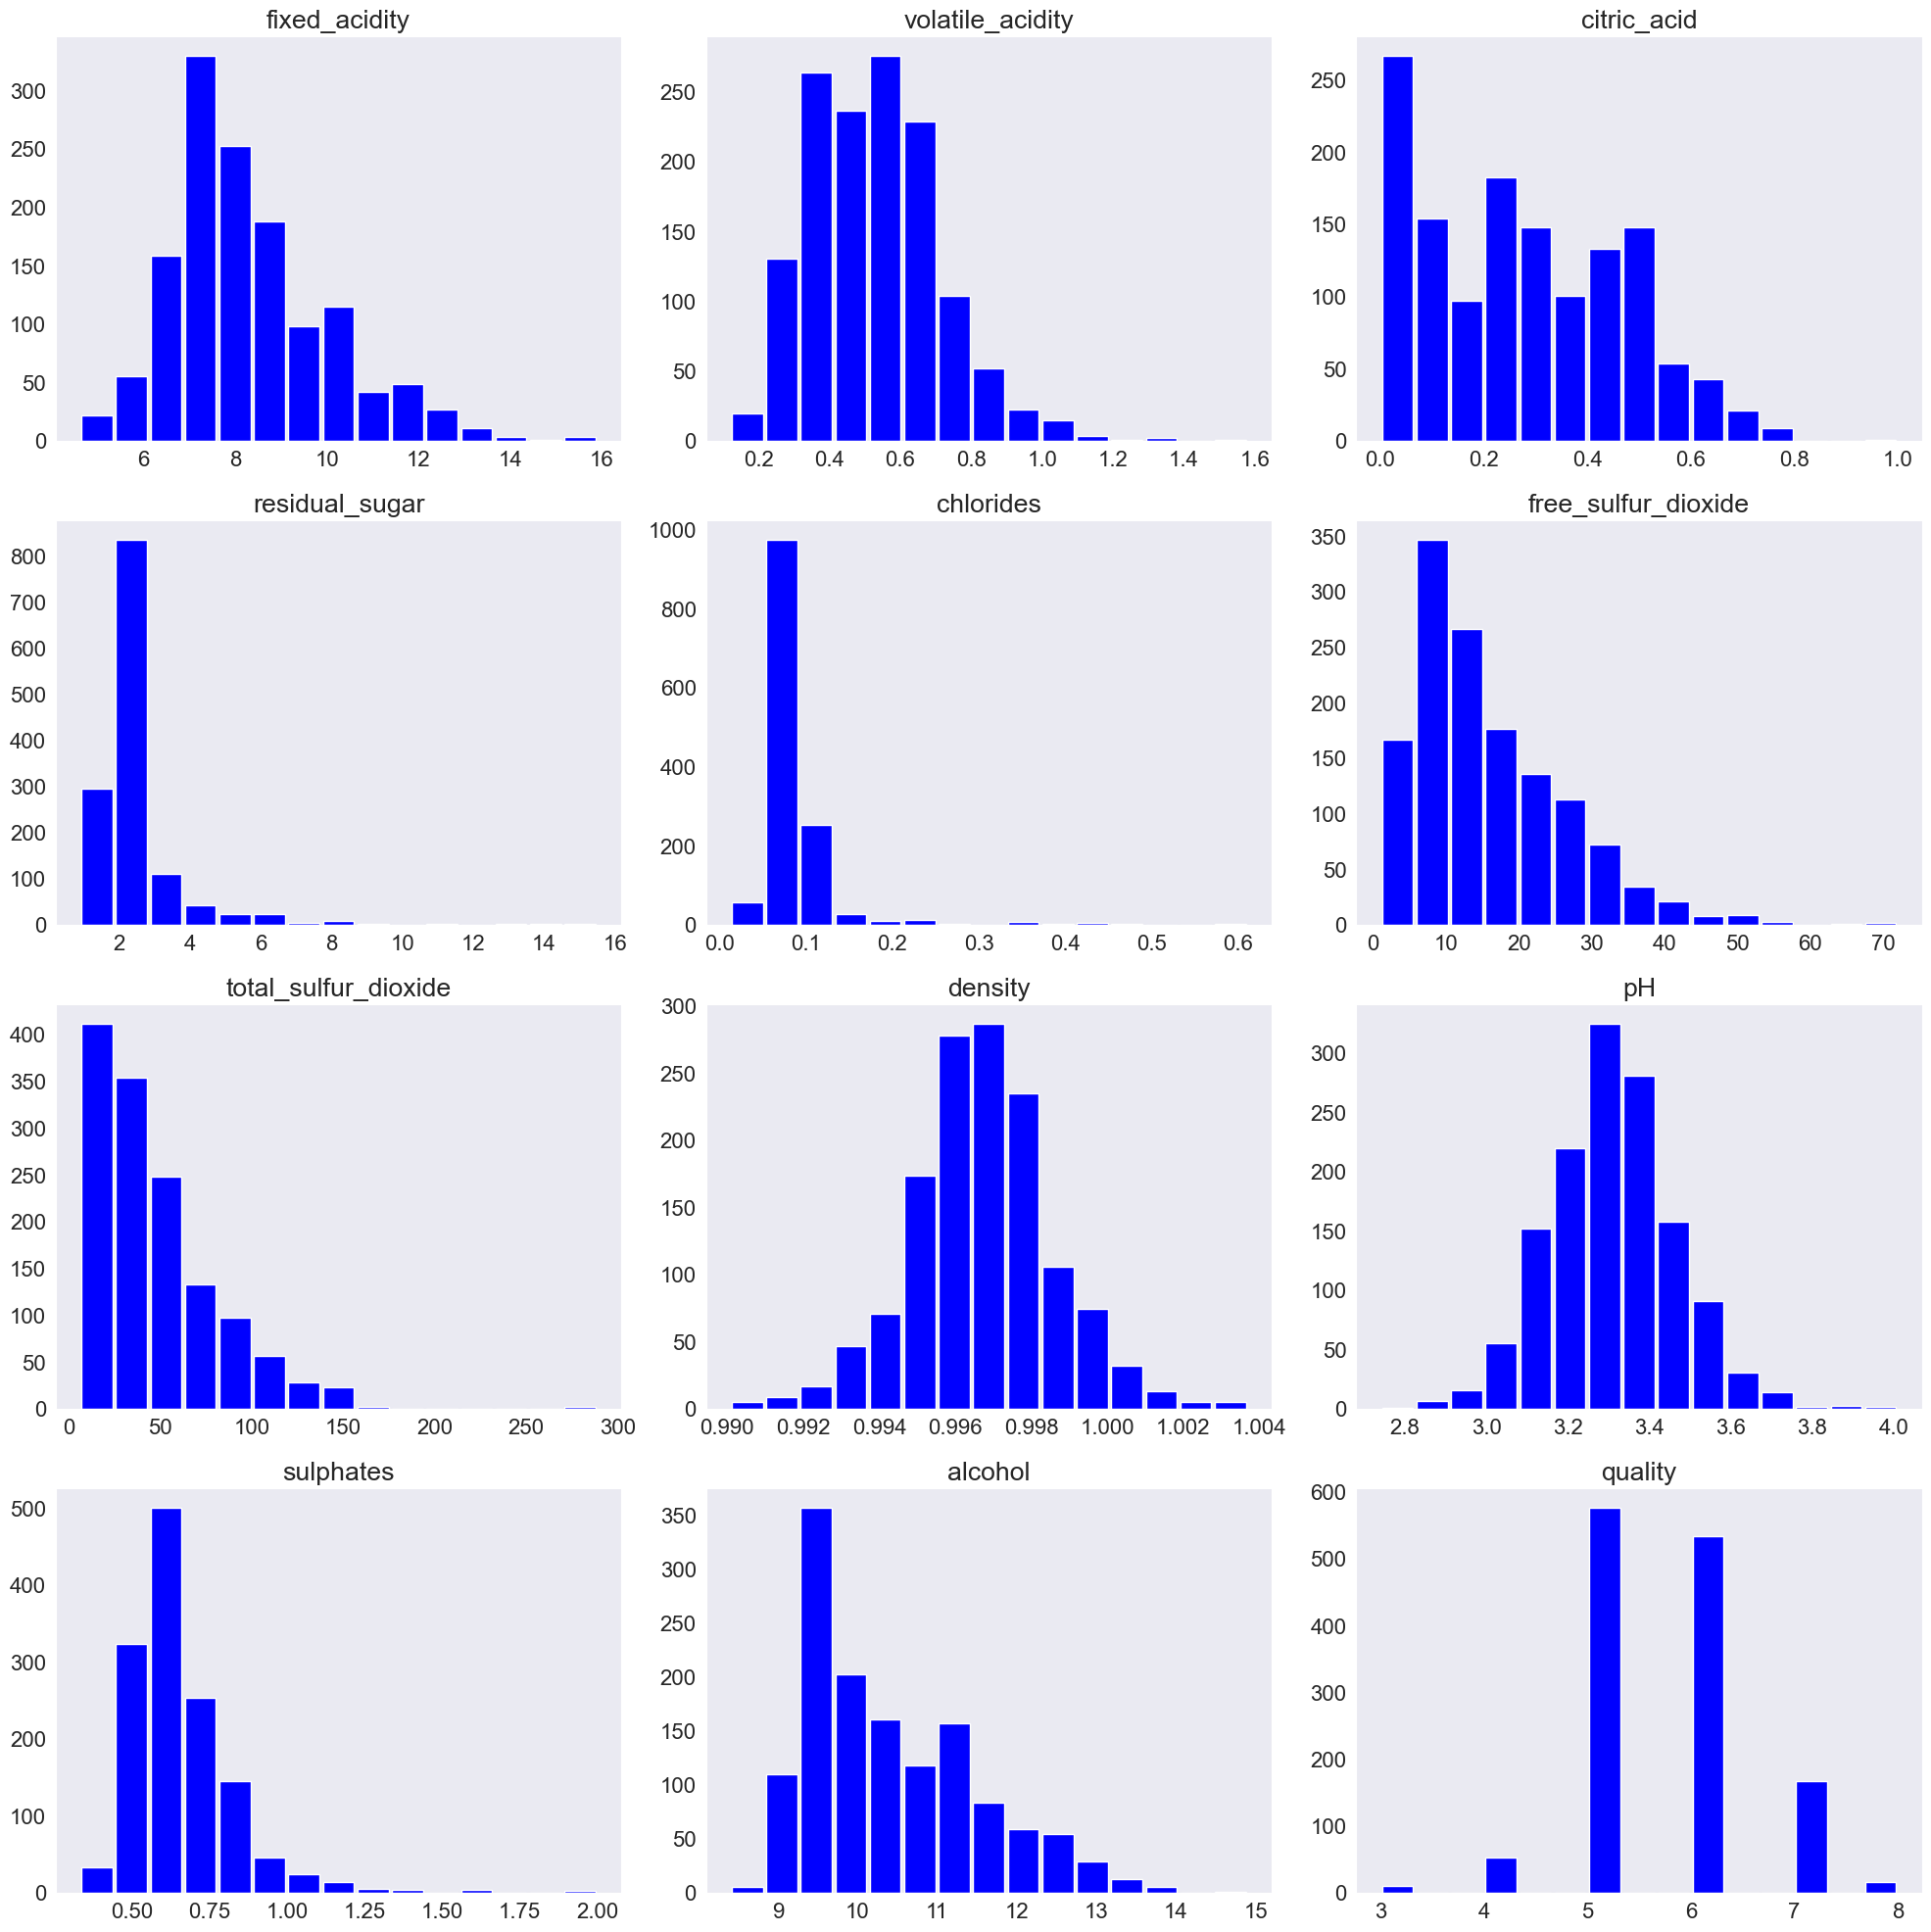

In [34]:
plt.figure(figsize=(15, 15))
red_df.hist(bins=15, grid=False, figsize=(20, 20), color='blue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.show()

### Splitting data into X and y

In [56]:
#define X and Y
X = combined_df.drop(['quality', 'wine_type_red'], axis=1)
y = pd.DataFrame(combined_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Applying Scalers and Transforms

### PowerTransformer on X

In [57]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_p = pd.DataFrame(pt.transform(X_train))
X_test_p= pd.DataFrame(pt.transform(X_test))


### PowerTransformer on y

In [58]:
pt_y = PowerTransformer(method='yeo-johnson')
pt_y.fit(y_train)
y_train_p = pt_y.transform(y_train)
y_test_p = pt_y.transform(y_test)


### MinMax Scaler on X

In [59]:
scaler_mm_x = MinMaxScaler()
scaler_mm_x.fit(X_train)
X_train_mm = scaler_mm_x.transform(X_train)
X_test_mm = scaler_mm_x.transform(X_test)

### MinMax Scaler on y

In [60]:
scaler_mm_y = MinMaxScaler()
scaler_mm_y.fit(y_train)
y_train_mm = scaler_mm_y.transform(y_train)
y_test_mm = scaler_mm_y.transform(y_test)

### Standard Scaler on X

In [61]:
scaler_s_x = StandardScaler()
scaler_s_x.fit(X_train)
X_train_s = scaler_s_x.transform(X_train)
X_test_s = scaler_s_x.transform(X_test)

### Standard Scaler on y

In [62]:
scaler_s_y = StandardScaler()
scaler_s_y.fit(y_train)
y_train_s = scaler_s_y.transform(y_train)
y_test_s = scaler_s_y.transform(y_test)

## Linear Regression Model 

In [65]:
coefficients = linear_regression(X_train_p, X_test_p, y_train_p, y_test_p)

model coefficients:
 [[-6.54668026e-02 -3.14100265e-02 -2.16665956e-01  5.90435109e-02
   1.07589348e-01 -9.75978045e-02  2.01593801e-01 -1.82978199e-01
  -6.86123402e-17  1.57571670e-02  1.20015636e-01  4.21955320e-01]]

model intercept:
 [2.18496811e-14]

Residuals:
         y_test    y_pred  residual
0     0.247423 -0.012040  0.259464
1     0.247423  0.261153 -0.013730
2     1.348051  0.959767  0.388284
3    -0.900972 -0.040601 -0.860372
4     0.247423  0.445715 -0.198292
...        ...       ...       ...
1325  0.247423  0.040860  0.206564
1326 -0.900972 -0.143101 -0.757871
1327 -0.900972  0.543036 -1.444008
1328  1.348051  0.937637  0.410414
1329 -0.900972 -0.909592  0.008619

[1330 rows x 3 columns]

Root mean squared error: 0.8286436743344974 

R2: 0.30135417083872673 

Adjusted R2: 0.2992461120129949 



In [ ]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train_p, y_train_p)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')

# Applying model to X test
y_pred = model.predict(X_test_p)
y_pred = pd.DataFrame(pt_y.inverse_transform(y_pred)) # inversing y

y_pred = y_pred_f_s.rename(columns = {0:"y_pred_f_s"})

y_test_f = y_test_f.reset_index(drop=True)
y_test_f = y_test_f.rename(columns = {"total_claim_amount":"y_test_f"})

In [68]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train_p, y_train_p)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')
    
# Applying model to X test
y_pred = model.predict(X_test_p)
y_pred = pd.DataFrame(pt_y.inverse_transform(y_pred)) # inversing y
    
# Ensure y_test_p is in the correct format (pandas Series or 1D numpy array)
if isinstance(y_test_p, pd.Series):
    y_test_p_reset = y_test_p.reset_index(drop=True)
else:
    y_test_p_reset = y_test_p  # Assuming y_test_p is already a numpy array
    
# Creating combined table with y_test_p and y_pred
# Check if y_test_p_reset is a pandas Series and convert y_pred to a similar type
if isinstance(y_test_p_reset, pd.Series):
    y_pred_series = pd.Series(y_pred, index=y_test_p_reset.index, name='y_pred')
    residuals_df = pd.concat([y_test_p_reset, y_pred_series], axis=1)
else:
    # If inputs are numpy arrays, stack them horizontally
    residuals_df = np.column_stack((y_test_p_reset, y_pred))
    # Convert to DataFrame for easier manipulation later on
    residuals_df = pd.DataFrame(residuals_df, columns=["y_test_p", "y_pred"])
    
# Calculating residuals
residuals_df["residual"] = residuals_df["y_test_p"] - residuals_df["y_pred"]
print(f'Residuals:\n {residuals_df}\n')

# Root mean squared error
rmse = mse(y_test_p_reset, residuals_df["y_pred"], squared=False)
print(f'Root mean squared error: {rmse} \n')

# R^2
r2 = r2_score(y_test_p_reset, residuals_df["y_pred"])
print(f'R2: {r2} \n')

# Calculating adjusted R^2
n = X_train_p.shape[0]  # Number of observations in the training set
p = X_train_p.shape[1]  # Number of features used for training
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2} \n')

model coefficients:
 [[-6.54668026e-02 -3.14100265e-02 -2.16665956e-01  5.90435109e-02
   1.07589348e-01 -9.75978045e-02  2.01593801e-01 -1.82978199e-01
  -6.86123402e-17  1.57571670e-02  1.20015636e-01  4.21955320e-01]]

model intercept:
 [2.18496811e-14]

Residuals:
       y_test_p    y_pred  residual
0     0.247423  5.770096 -5.522673
1     0.247423  6.012229 -5.764806
2     1.348051  6.642714 -5.294663
3    -0.900972  5.744929 -6.645902
4     0.247423  6.177226 -5.929803
...        ...       ...       ...
1325  0.247423  5.816785 -5.569362
1326 -0.900972  5.654836 -6.555808
1327 -0.900972  6.264686 -7.165658
1328  1.348051  6.622497 -5.274446
1329 -0.900972  4.992669 -5.893641

[1330 rows x 3 columns]

Root mean squared error: 5.848454903820645 

R2: -33.80196155315839 

Adjusted R2: -33.90697124353755 



/Users/jameskenny/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


## Feature Importance

In [13]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)

#Getting absolute values
fi_df_abs = fi_df['coeff'] = fi_df['coeff'].abs() 
#Sorting in descending order
fi_df_abs = fi_df.sort_values('coeff', ascending=False)

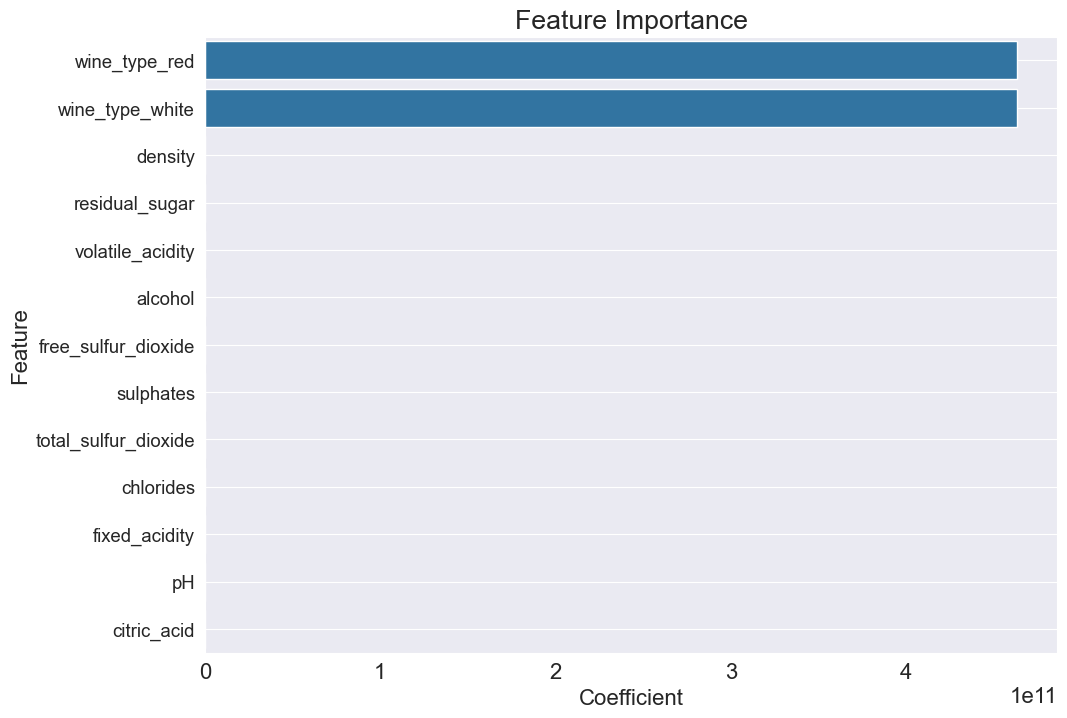

In [14]:
#Feature importance plot for standardized data
plt.figure(figsize=(11, 8))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df_abs)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()